<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Predictive_Modeling_for_Census_Income_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Modeling for Census Income Level

### **Project Overview**

* **Goal:** To develop a machine learning model to accurately predict whether an individual's annual income is greater than or less than/equal to $50,000.
* **Dataset:** Utilizes the "Adult" Census Income dataset from the UCI Machine Learning Repository.
* **Methodology:** The project involves exploratory data analysis (EDA) to understand feature distributions and their relationship with income. A robust preprocessing pipeline is built to handle missing values, scale numerical features, and one-hot encode categorical variables. An XGBoost classifier is then trained and evaluated on this processed data.
* **Key Results:** The model achieves a high accuracy of approximately **87%** and a ROC AUC score of **0.93**, indicating strong predictive performance.

***

### **Purpose**

* **Identify Key Determinants of Income:** To identify the most significant demographic and socio-economic factors (like age, education, and work class) that influence an individual's income level.
* **Build a Reliable Predictive Model:** To create an accurate classification model for income prediction, which can be applied to various socio-economic analyses.
* **Provide Actionable Insights:** To offer data-driven insights that could be valuable for applications such as targeted marketing, financial services, and public policy analysis.

### Dataset:
https://archive.ics.uci.edu/dataset/20/census+income

## IMPORT LIBRARIES

In [2]:
# Install XGBOOST
# !pip install -q xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import warnings

# Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")


Libraries imported successfully.


## LOAD AND PREPARE DATA

In [3]:
# Names as per the 'adult.names' file
# No headers - assign them manually.
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Load the training data from 'adult.data'.
train_df = pd.read_csv('/content/drive/MyDrive/Adult/adult.data', sep=', ', header=None, names=column_names, na_values='?', engine='python')
print("Training data loaded successfully. Shape:", train_df.shape)

# Load the test data from 'adult.test'.
test_df = pd.read_csv('/content/drive/MyDrive/Adult/adult.test', sep=', ', header=None, names=column_names, na_values='?', skiprows=1, engine='python')
print("Test data loaded successfully. Shape:", test_df.shape)


Training data loaded successfully. Shape: (32561, 15)
Test data loaded successfully. Shape: (16281, 15)


### Data Cleaning

In [4]:
# Same as training data's format
test_df['income'] = test_df['income'].str.replace(r'\.', '', regex=True)

# Combine train and test sets for a holistic view during EDA.
full_df = pd.concat([train_df, test_df], ignore_index=True)
print("\nCombined DataFrame created. Shape:", full_df.shape)


Combined DataFrame created. Shape: (48842, 15)


## EXPLORATORY DATA ANALYSIS (EDA)

### Target Variable Distribution

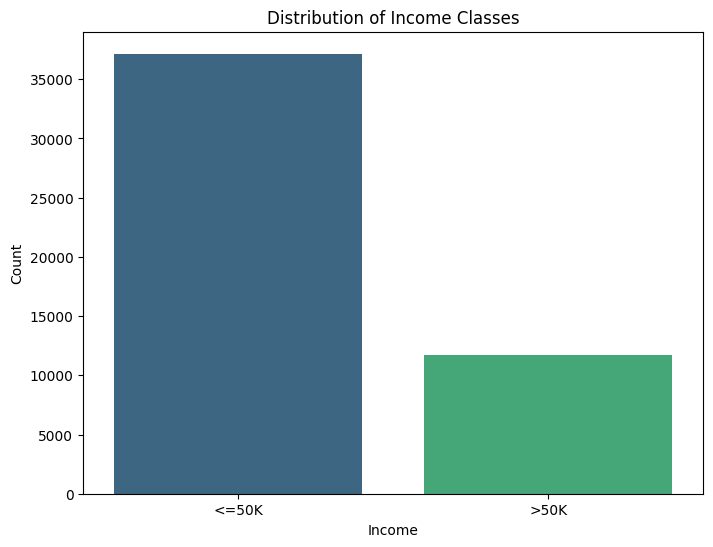

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=full_df, palette='viridis', order=full_df['income'].value_counts().index)
plt.title('Distribution of Income Classes')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

### Categorical Features Distribution

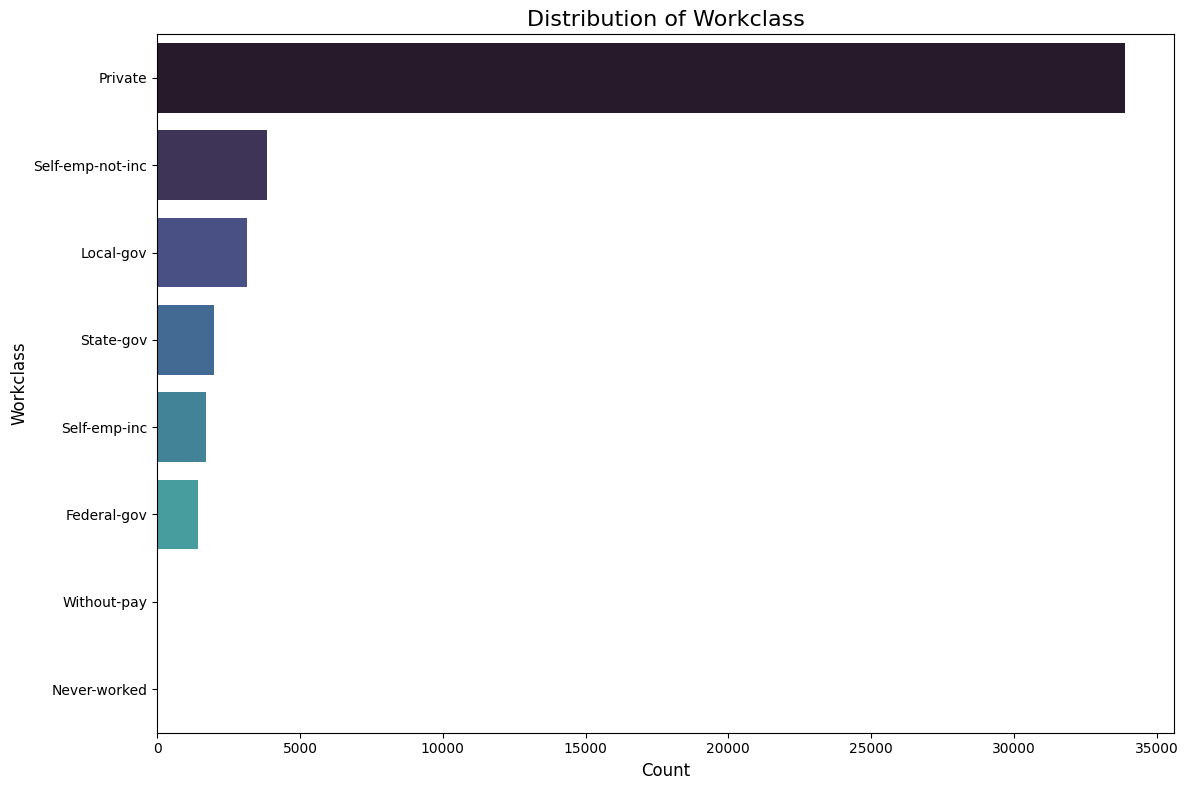

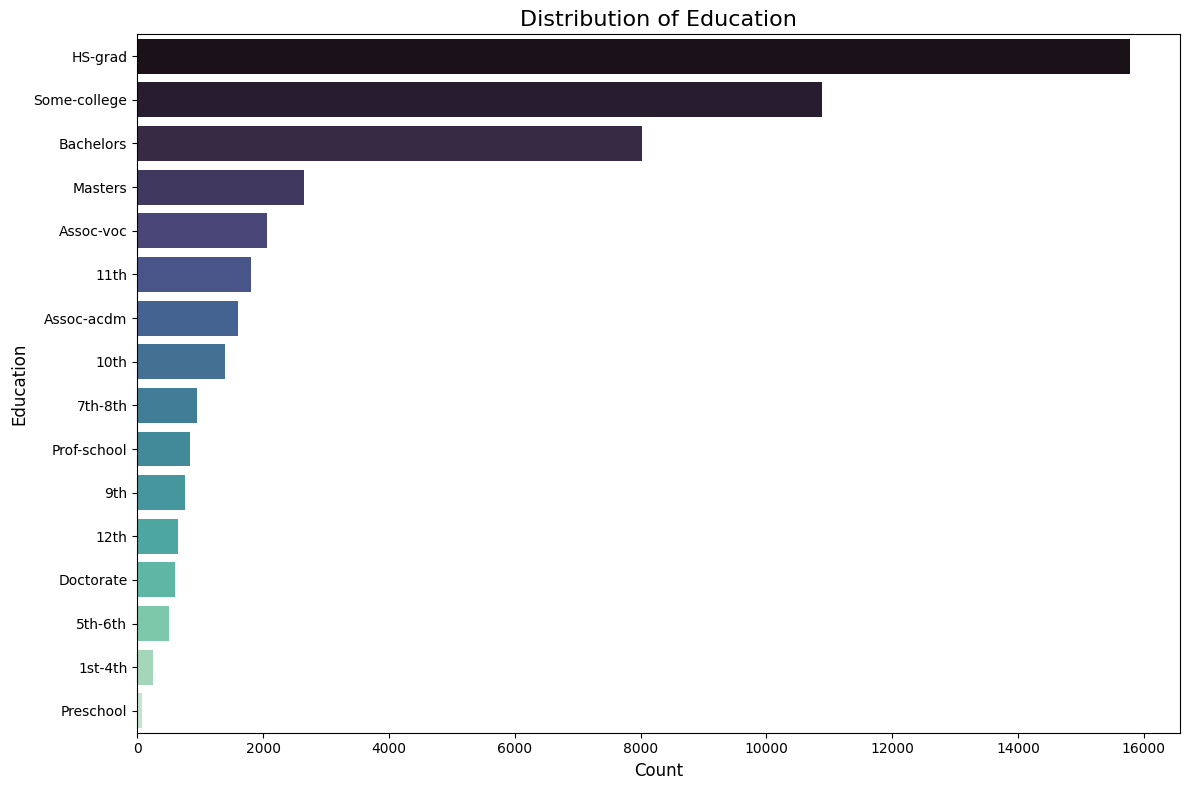

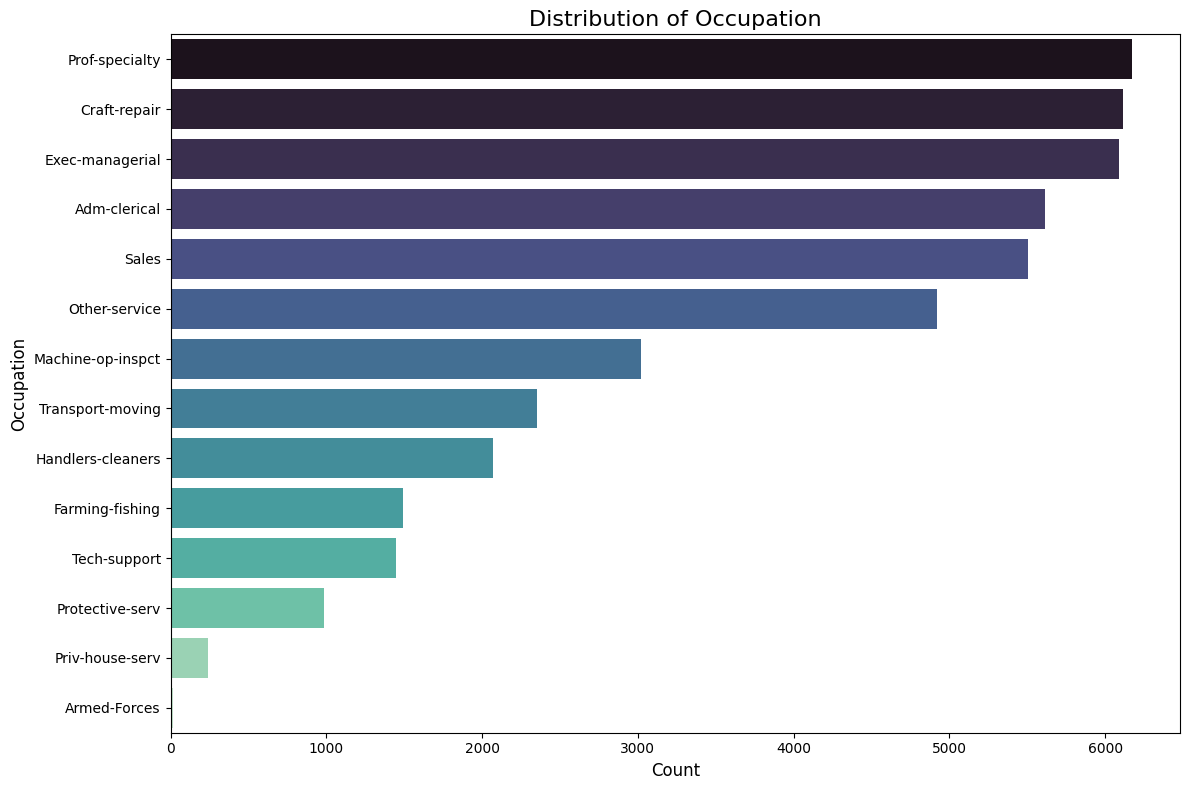

In [7]:
categorical_features_to_plot = ['workclass', 'education', 'occupation']
for col in categorical_features_to_plot:
    plt.figure(figsize=(12, 8))
    order = full_df[col].value_counts().index
    sns.countplot(y=col, data=full_df, order=order, palette='mako')
    plt.title(f'Distribution of {col.replace("-", " ").title()}', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col.replace("-", " ").title(), fontsize=12)
    plt.tight_layout()
    plt.show()

### Numerical Features Distribution

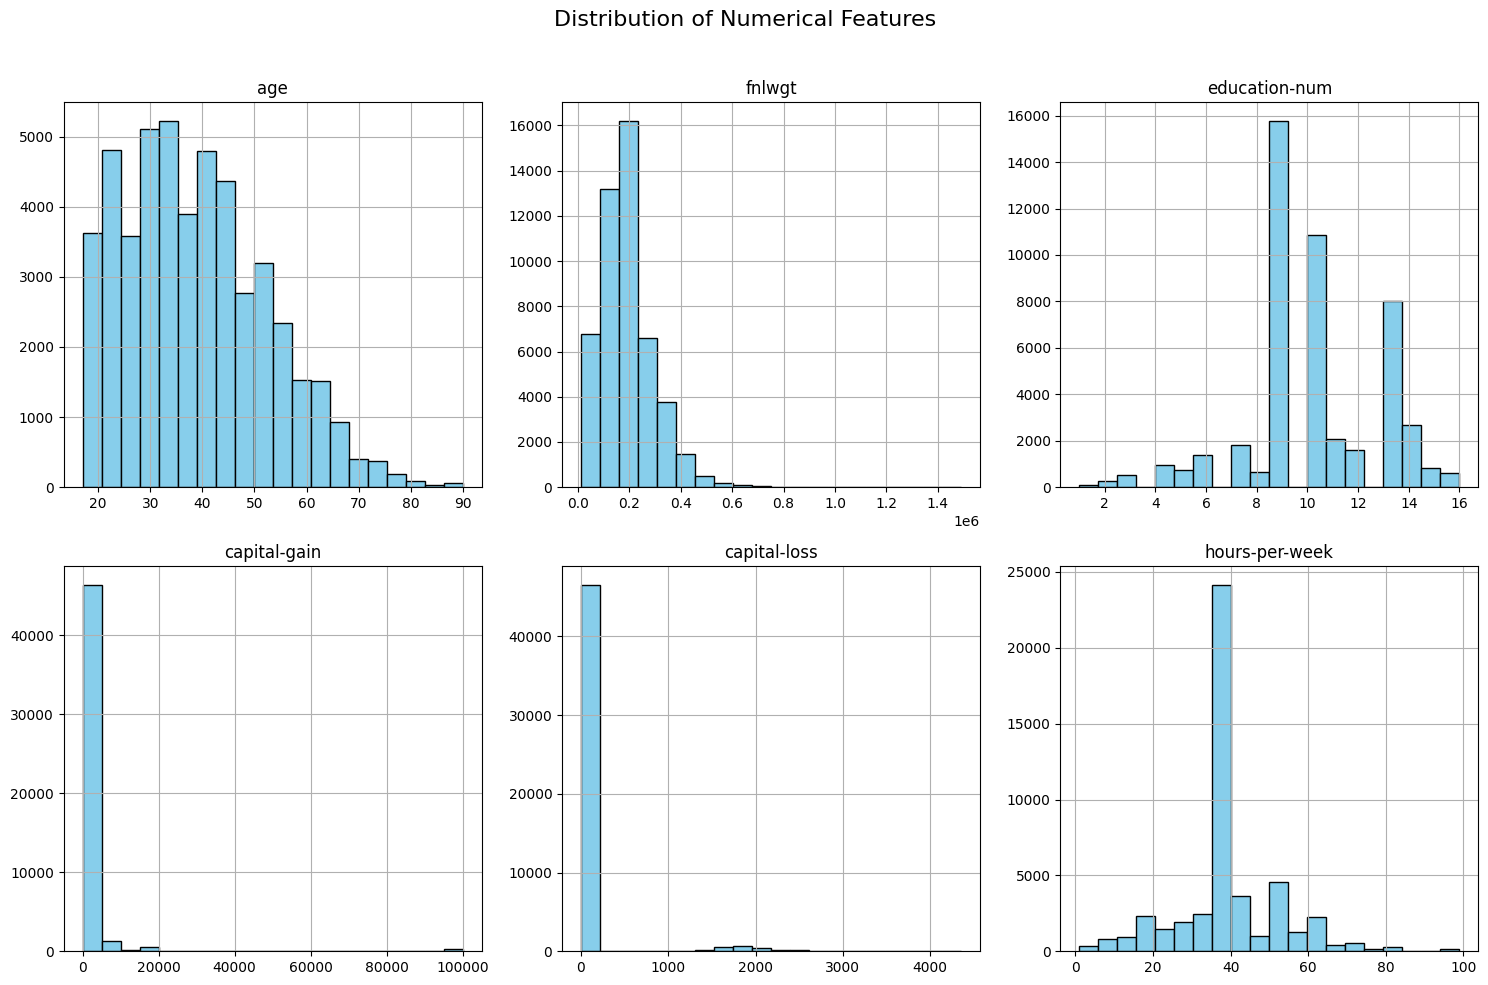

In [8]:
numerical_features = full_df.select_dtypes(include=np.number).columns.tolist()
full_df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(2, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## DATA PREPROCESSING

In [10]:
# Separate Features (X) and Target (y)
X_train = train_df.drop('income', axis=1)
y_train_raw = train_df['income']
X_test = test_df.drop('income', axis=1)
y_test_raw = test_df['income']

# Encode Target Variable
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)
print("Income Class Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Income Class Mapping: {'<=50K': np.int64(0), '>50K': np.int64(1)}


### Create Preprocessing Pipelines

In [11]:
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Combine Pipelines with ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

## MODEL TRAINING

In [12]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

## MODEL EVALUATION

In [13]:

y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Model Accuracy: 0.8737

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.94      0.92     12435
        >50K       0.78      0.65      0.71      3846

    accuracy                           0.87     16281
   macro avg       0.84      0.79      0.81     16281
weighted avg       0.87      0.87      0.87     16281



### Confusion Matrix

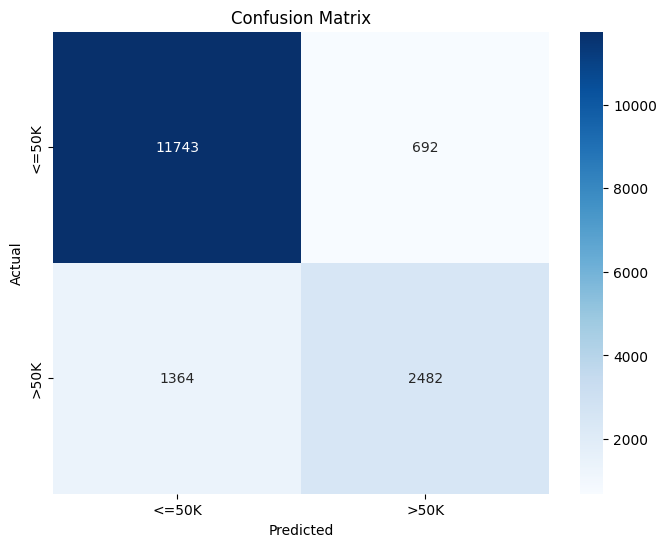

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### ROC Curve and AUC Score

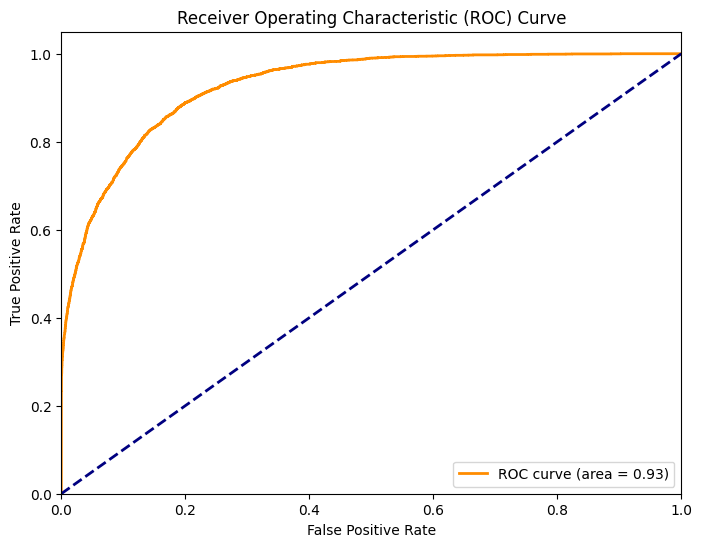

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()